### BRIA AI/RMBG-2.0 Segmentation Model Training and Inference

Fine-tuning pipeline for briaai/RMBG-2.0, a SOTA background removal model from HugginFace ([model card](https://huggingface.co/briaai/RMBG-2.0/))

This notebook contains:

1. **Single-CPU Training**
2. **Multi-GPU Training** with DDP, optimized for GPU clusters
3. **Inference**

### Requirements

In [0]:
!pip install -q --upgrade pip

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
!pip install -U -q mlflow transformers accelerate torch torchvision timm kornia safetensors pyspark

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Environment variables
import os
os.environ["DATABRICKS_HOST"] = "https://company.cloud.databricks.com"
os.environ["DATABRICKS_TOKEN"] = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True' # PyTorch memory allocator for GPU

#### Model Files

Download required model files from briaai/RMBG-2.0 HuggingFace repository, if needed.

In [0]:
from huggingface_hub import hf_hub_download

root_dir = Path("<PATH>")
model_dir = root_dir / "recipe_cropper" / "models" / "briaai"

model_dir.mkdir(exist_ok=True, parents=True)

# Download necessary files
required_files = [
    "birefnet.py",
    "BiRefNet_config.py",
    "config.json",
    "preprocessor_config.json",
    "model.safetensors"
]

for filename in required_files:
    hf_hub_download(
        repo_id="briaai/RMBG-2.0",
        filename=filename,
        local_dir=model_dir,
        local_dir_use_symlinks=False
    )

### Dataset

Custom PyTorch datasets for training briaai/RMBG-2.0 segmentation model:

**`BriaaiDataset`**
  - Handles image/mask paris with optional augmentation
  - Applies normalization and resizing transformations in line with [preprocessor_config.json](https://huggingface.co/briaai/RMBG-2.0/blob/main/preprocessor_config.json)

Built for use with briaai/RMBG-2.0 ([model files](https://huggingface.co/briaai/RMBG-2.0/tree/main)).

In [0]:
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset, DataLoader

class BriaaiDataset(Dataset):
    """
    Dataset class for briaai/RMBG-2.0.
    Model card: https://huggingface.co/briaai/RMBG-2.0
    
    Args:
        image_dir: Path to dir containing images.
        mask_dir: Path to dir containing masks.
        image_files: List of image file names.
        mask_files: List of mask file names.
        augmentation: Whether to apply data augmentation.
        image_size: Size of the images to be returned. # TODO: Check this
    """
    def __init__(self,
                 image_dir: Path,
                 mask_dir: Path,
                 image_files: list[str] = None,
                 mask_files: list[str] = None,
                 augmentation: bool = False,
                 image_size: tuple = (1024, 1024)
                 ):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.image_files = image_files
        self.mask_files = mask_files
        self.augmentation = augmentation
        self.image_size = image_size

        # Validate matching files
        if len(self.image_files) != len(self.mask_files):
            raise ValueError(f"Number of images ({len(self.image_files)}) and masks ({len(self.mask_files)}) must match")

        # Define preprocessing transofmrations
        self.image_transform = T.Compose([
            T.Resize(self.image_size),
            T.ToTensor(),
            T.Lambda(lambda x: x * 0.00392156862745098),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.mask_transform = T.Compose([
            T.Resize(self.image_size),
            T.ToTensor()
        ])

    def __len__(self) -> int:
        """Total number of image/mask pairs in the dataset."""
        return len(self.image_files)
    
    def __getitem__(self, idx: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get an image, its mask, prompt points, and point labels.
        
        Args:
            idx: Index of the image/mask pair

        Returns:
            (image, mask): Tuple containing:
                image_tensor: Normalized RGB image tensor of shape (3, H, W)
                mask_tensor: Binary mask tensor of shape (H, W)
        """
        # Load image and mask
        image_path = self.image_dir / self.image_files[idx]
        mask_path = self.mask_dir / self.mask_files[idx]

        # Convert to RGB and grayscale
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply augmentation if enabled
        if self.augmentation:
            seed = torch.randint(0, 2**32, (1,)).item()
            image, mask = augment(image, mask, seed)

        # Convert mask to binary
        binary_mask = (np.array(mask) > 0).astype(np.uint8)

        # Apply transformations
        image_tensor = self.image_transform(image)

        mask_tensor = torch.from_numpy(binary_mask)
        mask_tensor = F.interpolate(
            mask_tensor.unsqueeze(0).unsqueeze(0), # Add batch and channel dims
            size=self.image_size,
            mode="nearest"
        ).squeeze(0).squeeze(0) # Remove batch and channel dims

        return image_tensor, mask_tensor


#### Data Augmentation

In [0]:
import random
import torch
from PIL import Image
import torchvision.transforms as T

# Data Augmentation
def augment(image: Image.Image, mask: Image.Image, seed: int) -> tuple[Image.Image, Image.Image]:
    """
    Applies data augmentation to an image and its mask.

    Performs the following augmentations in sequence:
        1. Color jitter (image only): Randomly changes brightness, contrast, saturation, and hue.
        2. Random affine transformation: Applies random rotation, translation, scaling, and shearing.
        3. Horizontal flip: Randomly flips the image and mask horizontally.
        4. Vertical flip: Randomfly flips the image and mask vertically.

    Args:
        image: The input image to be augmented.
        mask: The corresponding segmentation mask of the input image.
        seed: Random seed for reproducibility.

    Returns:
        Tuple with the the augmented (image, mask) pair.
    """
    torch.manual_seed(seed)

    # ColorJitter
    color_jitter = T.ColorJitter(
        brightness=0.5,
        contrast=0.5,
        saturation=0.5,
        hue=0.2
    )
    image = color_jitter(image)

    # RandomAffine
    affine = T.RandomAffine(
        degrees=30,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=10
    ) # Set affine params once and apply to both image and mask
    params = affine.get_params(affine.degrees, affine.translate, affine.scale, affine.shear, image.size)
    image = T.functional.affine(image, *params)
    mask = T.functional.affine(mask, *params)

    # Horizontal Flip
    if random.random() > 0.5:
        image = T.functional.hflip(image)
        mask = T.functional.hflip(mask)

    # Vertical Flip
    if random.random() > 0.5:
        image = T.functional.vflip(image)
        mask = T.functional.vflip(mask)

    return image, mask

#### Creating datasets 
`train` / `validation` / `test` splits

In [0]:
from sklearn.model_selection import train_test_split

# Path to dataset
root_dir = Path("<PATH>")
DATASET_DIR = root_dir / "recipe_cropper" / "dataset" / "step" / "dataset_20dec"
img_dir = DATASET_DIR / "images"
mask_dir = DATASET_DIR / "annotations"

# List all image and mask files
VALID_IMAGE_EXTENSIONS = {".png", ".jpg", ".jpeg"}
VALID_MASK_EXTENSIONS = {".png", ".jpg"}
image_files = sorted([f.name for f in img_dir.iterdir() if f.suffix.lower() in VALID_IMAGE_EXTENSIONS])
mask_files = sorted([f.name for f in mask_dir.iterdir() if f.suffix.lower() in VALID_MASK_EXTENSIONS])

# Split data intro train/val/test sets
train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.1, random_state=42)
train_imgs, valid_imgs, train_masks, valid_masks = train_test_split(train_imgs, train_masks, test_size=0.2, random_state=42)

# Create dataset instances
train_dataset = BriaaiDataset(img_dir, mask_dir, train_imgs, train_masks, augmentation=False)
valid_dataset = BriaaiDataset(img_dir, mask_dir, valid_imgs, valid_masks, augmentation=False)
test_dataset = BriaaiDataset(img_dir, mask_dir, test_imgs, test_masks, augmentation=False)

In [0]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))
print("Number of testing examples:", len(test_dataset))

### Train Model

#### Functions `train` and `evaluate`

- `train()`: Single epoch training with gradient clipping
- `evaluate()`: Validation with multiple metrics (IoU, F1 Score, ROC-AUC)
- Optimized for CPU with standard backpropagation
- Tracks binary metrics for foreground/background segmentation

In [0]:
from torch.nn.utils import clip_grad_norm_
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import jaccard_score, f1_score, roc_auc_score
import numpy as np
from transformers import AutoModelForImageSegmentation

def train(model: AutoModelForImageSegmentation,
          dataloader: DataLoader,
          optimizer: AdamW,
          device: torch.device) -> tuple[float, float, float]:
    """
    Trains the biraai/RMBG-2.0 model for one epoch.

    Args:
        model: biraai/RMBG-2.0 model for semantic segmentation.
        dataloader: DataLoader for training data.
        optimizer: AdamW optimizer for training.
        device: Device to run training on.
    
    Returns:
        tuple: (Average loss, IoU, F1 score) for the training epoch.
    """
    model.train() # Set to training mode

    # To track loss
    total_loss = 0
    # To track IoU and F1-score
    all_preds = []
    all_masks = []

    for i, batch in enumerate(tqdm(dataloader)):
        # Get batch data
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        logits = outputs[0][0][0][0]
        logits = F.interpolate(
            logits,
            size=(1024, 1024),
            mode="bilinear",
            align_corners=False
        )
        loss = F.binary_cross_entropy_with_logits(logits, masks.unsqueeze(1).float())

        # Backward pass
        loss.backward() # Backpropagate

        clip_grad_norm_(model.parameters(), max_norm=1.0) # Clip to prevent exploding gradients
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        total_loss += loss.item() # Accumulate loss

        # Calculate predictions
        with torch.no_grad():
            preds = (torch.sigmoid(logits) > 0.5).float()
            preds = preds.squeeze(1)
            masks = masks.squeeze(1)
            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(masks.cpu().numpy().flatten())

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)
    assert all_preds.shape == all_masks.shape, f"Inconsistent shapes: {all_preds.shape} and {all_masks.shape}"

    # Calculate IoU and F1-score
    iou = jaccard_score(all_masks, all_preds, average="binary")
    f1 = f1_score(all_masks, all_preds, average="binary")

    return avg_loss, iou, f1
    
def evaluate(model: AutoModelForImageSegmentation,
             dataloader: DataLoader,
             device: torch.device) -> tuple[float, float, float, float]:
    """
    Evaluates the briaai/RMBG-2.0 model.

    Args:
        model: biraai/RMBG-2.0 model for semantic segmentation.
        dataloader: DataLoader for validation data.
        device: Device to run evaluation on.

    Returns:
        tuple: (Averge loss, IoU, F1 score, ROC-AUC score) for the validation epoch.
    """
    model.eval()

    # To track loss
    total_loss = 0
    # To track IoU and F1-score
    all_preds = []
    all_masks = []
    # To track ROC-AUC score
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            logits = outputs[3]
            logits = F.interpolate(
                logits,
                size=(1024, 1024),
                mode="bilinear",
                align_corners=False
            )
            loss = F.binary_cross_entropy_with_logits(logits, masks.unsqueeze(1).float())

            total_loss += loss.item() # Accumulate loss

            # Calculate predictions and probabilities
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            preds = preds.squeeze(1)
            probs = probs.squeeze(1)
            masks = masks.squeeze(1)

            # Store predictions, masks, and probabilities
            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(masks.cpu().numpy().flatten())
            all_probs.append(probs.cpu().numpy().flatten())

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)
    all_probs = np.concatenate(all_probs)
    assert all_preds.shape == all_masks.shape, f"Inconsistent shapes: {all_preds.shape} and {all_masks.shape}" # Validate shapes

    # Calculate IoU and F1-score
    iou = jaccard_score(all_masks, all_preds, average="binary")
    f1 = f1_score(all_masks, all_preds, average="binary")

    # Calculate ROC-AUC score if possible
    if len(np.unique(all_masks)) == 2:
        assert all_probs.shape == all_masks.shape, f"Inconsistent shapes for ROC AUC: {all_probs.shape} and {all_masks.shape}"
        roc_auc = roc_auc_score(all_masks, all_probs)
    else:
        roc_auc = float('nan')

    return avg_loss, iou, f1, roc_auc

#### Early stopping

In [0]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

# Early Stopping
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        patience: Epochs to wait after last improvement of the validation metric.
        delta: Minimum change to qualify as an improvement.
        mode: Either "min" or "max". "min" stops when metric stops decreasing,
            "max" stops when metric stops increasing. Default: "min".
        verbose: If True, prints messages for metric improvements. Default: False.

    Example:
        early_stopping = EarlyStopping(patience=5, mode="max", verbose=True)
        for epoch in range(num_epochs):
            val_iou = validate_model()
            early_stopping(val_iou, model, optimizer, scheduler, save_path)
            if early_stopping.early_stop:
                break
    """
    def __init__(self,
                 patience: int = 5,
                 delta: float = 0,
                 mode: str = "min",
                 verbose: bool = True):
        if mode not in ["min", "max"]:
            raise ValueError(f"Mode {mode} is not supported. Use 'min' or 'max'.")

        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.verbose = verbose
        self.best_score = -float("inf") if self.mode == "max" else float("inf")
        self.early_stop = False
        self.counter = 0
        self.best_epoch = None

    def __call__(self,
                 epoch: int,
                 metric: float,
                 model: AutoModelForImageSegmentation,
                 optimizer: Optimizer,
                 scheduler: _LRScheduler,
                 path: Path):
        """
        Checks early stopping conditions and save the model if metric improves.

        Args:
            epoch: Current epoch number
            metric: Current validation metric value
            model: briaai/RMBG-2.0 model
            optimizer: Optimizer instance
            scheduler: Learning rate scheduler
            path: Path to save the checkpoint
        """
        score = metric if self.mode == "max" else -metric

        # Check if metric improved
        improvement = False
        if self.mode == "min":
            improvement = score < self.best_score - self.delta
        elif self.mode == "max":
            improvement = score > self.best_score + self.delta

        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            self.save_best_model(epoch, metric, model, path)
        elif improvement:
            if self.verbose:
                print(f"Validation metric improved ({self.best_score:.4f} --> {score:.4f}). Saving model...")
            self.best_score = score
            self.best_epoch = epoch
            self.save_best_model(epoch, metric, model, path)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self,
                        epoch: int,
                        metric: float,
                        model: AutoModelForImageSegmentation,
                        optimizer: Optimizer,
                        scheduler: _LRScheduler,
                        path: Path):
        """
        Save complete training state when validation metric improves.
        
        Args:
            epoch: Current epoch number.
            metric: Current validation metric value.
            model: Model to save if metric improves.
            optimizer. Optimizer state to save.
            scheduer: Scheduler state to save.
            path: Path to save the model checkpoint.
        """
        path.parent.mkdir(exist_ok=True, parents=True)

        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "metric_value": metric,
            "best_score": self.best_score,
        }

        # Save checkpoint
        torch.save(checkpoint, path)

        if self.verbose:
            print(f"Saved checkpoint at epoch {epoch} with metric value: {metric:.4f}")

    def save_best_model(self,
                        epoch: int,
                        metric: float,
                        model: AutoModelForImageSegmentation,
                        path: Path):
        """
        Save best model.

        Args:
            epoch: Current epoch number.
            metric: Current validation metric value.
            model: Model to save.
            path: Path to save the best model.
        """
        path.parent.mkdir(exist_ok=True, parents=True)

        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "best_score": self.best_score,
        }

        best_path = path.parent / "best_model.pt" if path.name != "best_model.pt" else path

        # Save best model
        if metric == self.best_score:
            torch.save(checkpoint, best_path)
            print(f"[Best model] Saved best model at epoch {epoch} with metric value: {metric:.4f}")

#### 1. Training with: `train` / `validation` / `test` splits.

Training pipeline for CPU-based fine-tuning a BiRefNet model (based on briaai/RMBG-2.0) for image segmentation.

Best model is saved based on validation IoU.

In [0]:
# Utility function to track memory usage across CPU/GPU
# Useful for debugging OOM errors

import psutil
import gc

def log_memory_usage():
    """Logs memory usage for debugging."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 3)  # in GB
        reserved = torch.cuda.memory_reserved() / (1024 ** 3)  # in GB
        print(f"GPU Memory: Allocated={allocated:.2f}GB, Reserved={reserved:.2f}GB")
    else:
        process = psutil.Process()
        memory_info = process.memory_info()
        rss = memory_info.rss / (1024 ** 3)  # in GB
        print(f"CPU Memory: RSS={rss:.2f}GB")

gc.collect() # Free CPU memory
torch.cuda.empty_cache() # Free GPU memory

In [0]:
## Add briaai/RMBG-2.0 model files to Python path and import them

root_dir = Path("<PATH>")
models_dir = root_dir / "recipe_cropper" / "models"

import sys
from pathlib import Path

sys.path = [p for p in sys.path if str(models_dir) != str(Path(p))]  # Clear sys.path of any previous models_dir
sys.path.insert(0, str(models_dir)) # Add models_dir

from briaai.birefnet import BiRefNet
from briaai.BiRefNet_config import BiRefNetConfig

In [0]:
import mlflow
from torch.optim.lr_scheduler import ReduceLROnPlateau
from safetensors.torch import load_file

root_dir = Path("<PATH>")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CONSTANTS
MODEL_NAME = "briaai/RMBG-2.0"
CHECKPOINT_DIR = root_dir / "recipe_cropper" / "checkpoints" / "2025_01_28" / "briaai"
SAVE_INTERVAL = 4 # Checkpoint save interval
NUM_EPOCHS = 50
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 8
PATIENCE = 12  # Early stopping patience

CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True) # Create checkpoint dir

# Create DataLoaders - note: pin_memory is only relevant when using GPU
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, persistent_workers=True)

# Initialize model
import json
with open(models_dir / "briaai" / "config.json", "r") as f:
    config = json.load(f)

# Initialize model from local files
model = BiRefNet(BiRefNetConfig(**config))

state_dict = load_file(models_dir / "briaai" / "model.safetensors")
model.load_state_dict(state_dict)
model.to(device)

# Initialize optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=4)

# Initialize early stopping
early_stopping = EarlyStopping(patience=PATIENCE, mode="max", verbose=True)

with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_params({
        "model_name": MODEL_NAME,
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "batch_size": BATCH_SIZE,
        "num_epochs": NUM_EPOCHS,
        })
    print(f"\nLearning rate: {LEARNING_RATE}, Batch size: {BATCH_SIZE}")

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        log_memory_usage() # Debug
        
        # Train model
        train_loss, train_iou, train_f1 = train(model, train_dataloader, optimizer, device)

        log_memory_usage() # Debug

        # Evaluate model
        val_loss, val_iou, val_f1, val_roc_auc = evaluate(model, valid_dataloader, device)

        log_memory_usage() # Debug

        # Log metrics
        metrics = {
            "train_loss": train_loss,
            "train_iou": train_iou,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_f1": val_f1,
            "val_roc_auc": val_roc_auc,
        }
        mlflow.log_metrics(metrics, step=epoch)

        print(f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, F1-Score: {train_f1:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, F1-Score: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

        # Step the scheduler
        scheduler.step(val_iou)

        # Save model checkpoint
        if epoch % SAVE_INTERVAL == 0:
            checkpoint_path = CHECKPOINT_DIR / f"epoch_{epoch}.pt"
            early_stopping.save_checkpoint(epoch, val_iou, model, optimizer, scheduler, checkpoint_path)

        # Check early stopping
        best_model_path = CHECKPOINT_DIR / "best_model.pt"
        early_stopping(epoch, val_iou, model, optimizer, scheduler, best_model_path)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

# Load best model checkpoint from state dict
best_model_checkpoint = torch.load(best_model_path)
model.load_state_dict(best_model_checkpoint["model_state_dict"])
model.to(device)

# Evaluate best model on test set
test_loss, test_iou, test_f1, test_roc_auc = evaluate(model, test_dataloader, device)
print(f"\nFinal results: \nBest model test results - Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, F1-Score: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")

print("\nModel fine-tuning complete.")

#### 2. Distributed training with `train` / `validation` / `test` splits

Distributed training pipeline for GPU-based fine-tuning a BiRefNet model (based on briaai/RMBG-2.0) for image segmentation.

Best model is saved based on validation IoU.

- Run script `train_dpp_v2.2_BRIAAI.py`

In [0]:
dbutils.fs.cp("<PATH>/recipe_cropper/code/train_ddp_v2_2_BRIAAI.py", "file:/tmp/train_ddp_v2_2_BRIAAI.py")
dbutils.fs.put("file:///root/.databrickscfg", "[DEFAULT]\nhost=https://community.cloud.databricks.com\ntoken = " + os.environ.get("DATABRICKS_TOKEN"), overwrite=True)

Wrote 98 bytes.


True

In [0]:
%sh python /tmp/train_ddp_v2_2_BRIAAI.py

/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5d04a2e-4572-4bd2-98cb-214963b6eae2/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
Thu Jan 30 07:37:15 2025 Connection to spark from PID  3302
Thu Jan 30 07:37:15 2025 Initialized gateway on port 46789
Thu Jan 30 07:37:15 2025 Connected to spark.


2025-01-30 07:37:22,573 - __main__ - INFO - Starting the distributed training script...


INFO:__main__:Starting the distributed training script...


2025-01-30 07:37:22,670 - __main__ - INFO - World size: 4


INFO:__main__:World size: 4
/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5d04a2e-4572-4bd2-98cb-214963b6eae2/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5d04a2e-4572-4bd2-98cb-214963b6eae2/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5d04a2e-4572-4bd2-98cb-214963b6eae2/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support 

2025-01-30 07:37:33,552 - __mp_main__ - INFO - Backend: nccl


INFO:__mp_main__:Backend: nccl


2025-01-30 07:37:33,604 - __mp_main__ - INFO - Backend: nccl


INFO:__mp_main__:Backend: nccl


2025-01-30 07:37:33,667 - __mp_main__ - INFO - Backend: nccl


INFO:__mp_main__:Backend: nccl


2025-01-30 07:37:33,671 - __mp_main__ - INFO - Backend: nccl


INFO:__mp_main__:Backend: nccl
[rank2]:[W130 07:37:39.948087160 ProcessGroupNCCL.cpp:4561] [PG ID 0 PG GUID 0 Rank 2]  using GPU 2 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect. Specify device_ids in barrier() to force use of a particular device, or call init_process_group() with a device_id.
[rank1]:[W130 07:37:39.960559932 ProcessGroupNCCL.cpp:4561] [PG ID 0 PG GUID 0 Rank 1]  using GPU 1 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect. Specify device_ids in barrier() to force use of a particular device, or call init_process_group() with a device_id.
[rank3]:[W130 07:37:39.975199667 ProcessGroupNCCL.cpp:4561] [PG ID 0 PG GUID 0 Rank 3]  using GPU 3 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping i

2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 0 - Number of training examples: 907
2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 1 - Number of training examples: 907
2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 3 - Number of training examples: 908


INFO:__mp_main__:Rank: 0 - Number of training examples: 907
INFO:__mp_main__:Rank: 1 - Number of training examples: 907
INFO:__mp_main__:Rank: 3 - Number of training examples: 908
INFO:__mp_main__:Rank: 0 - Number of validation examples: 227
INFO:__mp_main__:Rank: 1 - Number of validation examples: 227
INFO:__mp_main__:Rank: 3 - Number of validation examples: 227
INFO:__mp_main__:Rank: 2 - Number of training examples: 907
INFO:__mp_main__:Rank: 0 - Number of testing examples: 126
INFO:__mp_main__:Rank: 1 - Number of testing examples: 126
INFO:__mp_main__:Rank: 3 - Number of testing examples: 127
INFO:__mp_main__:Rank: 2 - Number of validation examples: 227
INFO:__mp_main__:Rank: 2 - Number of testing examples: 126


2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 0 - Number of validation examples: 227
2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 1 - Number of validation examples: 227
2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 3 - Number of validation examples: 227
2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 2 - Number of training examples: 907
2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 0 - Number of testing examples: 126
2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 1 - Number of testing examples: 126
2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 3 - Number of testing examples: 127
2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 2 - Number of validation examples: 227
2025-01-30 07:37:40,059 - __mp_main__ - INFO - Rank: 2 - Number of testing examples: 126
2025-01-30 07:38:48,444 - __mp_main__ - INFO - Learning rate: 1.0e-05, Weight decay: 1.0e-04, Batch size: 4
2025-01-30 07:38:48,444 - __mp_main__ - INFO - Epoch 1/20


  0%|          | 0/227 [00:00<?, ?it/s]INFO:__mp_main__:Learning rate: 1.0e-05, Weight decay: 1.0e-04, Batch size: 4
INFO:__mp_main__:Epoch 1/20


2025-01-30 07:38:48,444 - __mp_main__ - INFO - GPU:0 Memory: Allocated=1.64GB, Reserved=2.49GB, Peak=1.64GB


INFO:__mp_main__:GPU:0 Memory: Allocated=1.64GB, Reserved=2.49GB, Peak=1.64GB
  0%|          | 0/227 [00:00<?, ?it/s]/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5d04a2e-4572-4bd2-98cb-214963b6eae2/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5d04a2e-4572-4bd2-98cb-214963b6eae2/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5d04a2e-4572-4bd2-98cb-214963b6eae2/lib/python3.11/site-packages/torch/utils/

2025-01-30 08:12:25,702 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


2025-01-30 08:12:26,311 - __mp_main__ - INFO - Train Loss: 0.6474, IoU: 0.3588, F1-Score: 0.5281


INFO:__mp_main__:Train Loss: 0.6474, IoU: 0.3588, F1-Score: 0.5281


2025-01-30 08:12:26,311 - __mp_main__ - INFO - Validation Loss: 0.5504, IoU: 0.5230, F1-Score: 0.6868, ROC-AUC: 0.9960


INFO:__mp_main__:Validation Loss: 0.5504, IoU: 0.5230, F1-Score: 0.6868, ROC-AUC: 0.9960


2025-01-30 08:12:30,675 - __mp_main__ - INFO - Saved checkpoint at epoch 0 with metric value: 0.5230


INFO:__mp_main__:Saved checkpoint at epoch 0 with metric value: 0.5230


2025-01-30 08:12:30,676 - __mp_main__ - INFO - Validation metric improved (-inf --> 0.5230). Saving model...


INFO:__mp_main__:Validation metric improved (-inf --> 0.5230). Saving model...


2025-01-30 08:12:32,331 - __mp_main__ - INFO - [Best model] Saved best model at epoch 0 with metric value: 0.5230


INFO:__mp_main__:[Best model] Saved best model at epoch 0 with metric value: 0.5230


2025-01-30 08:12:32,332 - __mp_main__ - INFO - Epoch 2/20


INFO:__mp_main__:Epoch 2/20


2025-01-30 08:12:32,332 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB


INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB
 56%|█████▌    | 126/227 [03:29<02:49,  1.6

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 57/57 [00:25<00:00,  2.24it/s]


2025-01-30 08:45:06,128 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


2025-01-30 08:45:08,112 - __mp_main__ - INFO - Train Loss: 0.6273, IoU: 0.3965, F1-Score: 0.5679


INFO:__mp_main__:Train Loss: 0.6273, IoU: 0.3965, F1-Score: 0.5679


2025-01-30 08:45:08,112 - __mp_main__ - INFO - Validation Loss: 0.8077, IoU: 0.4133, F1-Score: 0.5848, ROC-AUC: 0.9952


INFO:__mp_main__:Validation Loss: 0.8077, IoU: 0.4133, F1-Score: 0.5848, ROC-AUC: 0.9952


2025-01-30 08:45:08,112 - __mp_main__ - INFO - EarlyStopping counter: 1/6
2025-01-30 08:45:08,112 - __mp_main__ - INFO - Epoch 3/20
2025-01-30 08:45:08,113 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB


INFO:__mp_main__:EarlyStopping counter: 1/6
INFO:__mp_main__:Epoch 3/20
INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB
 56%|█████▌    | 126/

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 57/57 [00:25<00:00,  2.24it/s]


2025-01-30 09:17:41,037 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


2025-01-30 09:17:41,816 - __mp_main__ - INFO - Train Loss: 0.6223, IoU: 0.6317, F1-Score: 0.7743
2025-01-30 09:17:41,816 - __mp_main__ - INFO - Validation Loss: 1.0337, IoU: 0.3645, F1-Score: 0.5342, ROC-AUC: 0.9949


INFO:__mp_main__:Train Loss: 0.6223, IoU: 0.6317, F1-Score: 0.7743
INFO:__mp_main__:Validation Loss: 1.0337, IoU: 0.3645, F1-Score: 0.5342, ROC-AUC: 0.9949


2025-01-30 09:17:46,257 - __mp_main__ - INFO - Saved checkpoint at epoch 2 with metric value: 0.3645


INFO:__mp_main__:Saved checkpoint at epoch 2 with metric value: 0.3645


2025-01-30 09:17:46,258 - __mp_main__ - INFO - EarlyStopping counter: 2/6
2025-01-30 09:17:46,258 - __mp_main__ - INFO - Epoch 4/20


INFO:__mp_main__:EarlyStopping counter: 2/6
INFO:__mp_main__:Epoch 4/20


2025-01-30 09:17:46,259 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB


INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB
 56%|█████▌    | 126/227 [03:29<02:49,  1.6

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 57/57 [00:25<00:00,  2.23it/s]


2025-01-30 09:50:16,672 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


2025-01-30 09:50:17,313 - __mp_main__ - INFO - Train Loss: 0.6183, IoU: 0.7215, F1-Score: 0.8382


INFO:__mp_main__:Train Loss: 0.6183, IoU: 0.7215, F1-Score: 0.8382


2025-01-30 09:50:17,313 - __mp_main__ - INFO - Validation Loss: 1.4150, IoU: 0.3100, F1-Score: 0.4733, ROC-AUC: 0.9941


INFO:__mp_main__:Validation Loss: 1.4150, IoU: 0.3100, F1-Score: 0.4733, ROC-AUC: 0.9941


2025-01-30 09:50:17,313 - __mp_main__ - INFO - EarlyStopping counter: 3/6
2025-01-30 09:50:17,313 - __mp_main__ - INFO - Epoch 5/20
2025-01-30 09:50:17,314 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB


INFO:__mp_main__:EarlyStopping counter: 3/6
INFO:__mp_main__:Epoch 5/20
INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB
 56%|█████▌    | 126/

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 57/57 [00:25<00:00,  2.23it/s]


2025-01-30 10:22:47,071 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


2025-01-30 10:22:47,757 - __mp_main__ - INFO - Train Loss: 0.6147, IoU: 0.7526, F1-Score: 0.8588
2025-01-30 10:22:47,757 - __mp_main__ - INFO - Validation Loss: 1.2230, IoU: 0.3366, F1-Score: 0.5037, ROC-AUC: 0.9941


INFO:__mp_main__:Train Loss: 0.6147, IoU: 0.7526, F1-Score: 0.8588
INFO:__mp_main__:Validation Loss: 1.2230, IoU: 0.3366, F1-Score: 0.5037, ROC-AUC: 0.9941


2025-01-30 10:22:52,196 - __mp_main__ - INFO - Saved checkpoint at epoch 4 with metric value: 0.3366


INFO:__mp_main__:Saved checkpoint at epoch 4 with metric value: 0.3366


2025-01-30 10:22:52,197 - __mp_main__ - INFO - EarlyStopping counter: 4/6
2025-01-30 10:22:52,198 - __mp_main__ - INFO - Epoch 6/20


INFO:__mp_main__:EarlyStopping counter: 4/6
INFO:__mp_main__:Epoch 6/20


2025-01-30 10:22:52,198 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB


INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB
 56%|█████▌    | 126/227 [03:30<02:48,  1.6

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 57/57 [00:25<00:00,  2.24it/s]


2025-01-30 10:55:24,892 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


2025-01-30 10:55:25,509 - __mp_main__ - INFO - Train Loss: 0.6113, IoU: 0.7746, F1-Score: 0.8730


INFO:__mp_main__:Train Loss: 0.6113, IoU: 0.7746, F1-Score: 0.8730
INFO:__mp_main__:Validation Loss: 1.6795, IoU: 0.2901, F1-Score: 0.4497, ROC-AUC: 0.9928


2025-01-30 10:55:25,509 - __mp_main__ - INFO - Validation Loss: 1.6795, IoU: 0.2901, F1-Score: 0.4497, ROC-AUC: 0.9928
2025-01-30 10:55:25,509 - __mp_main__ - INFO - EarlyStopping counter: 5/6
2025-01-30 10:55:25,510 - __mp_main__ - INFO - Epoch 7/20
2025-01-30 10:55:25,510 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB


INFO:__mp_main__:EarlyStopping counter: 5/6
INFO:__mp_main__:Epoch 7/20
INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=3.94GB, Peak=3.30GB
 56%|█████▌    | 126/

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 57/57 [00:25<00:00,  2.23it/s]


2025-01-30 11:27:55,326 - __mp_main__ - INFO - GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


INFO:__mp_main__:GPU:0 Memory: Allocated=3.30GB, Reserved=10.46GB, Peak=16.84GB


2025-01-30 11:27:56,049 - __mp_main__ - INFO - Train Loss: 0.6082, IoU: 0.7882, F1-Score: 0.8815
2025-01-30 11:27:56,049 - __mp_main__ - INFO - Validation Loss: 1.4661, IoU: 0.3049, F1-Score: 0.4673, ROC-AUC: 0.9933


INFO:__mp_main__:Train Loss: 0.6082, IoU: 0.7882, F1-Score: 0.8815
INFO:__mp_main__:Validation Loss: 1.4661, IoU: 0.3049, F1-Score: 0.4673, ROC-AUC: 0.9933


2025-01-30 11:28:00,484 - __mp_main__ - INFO - Saved checkpoint at epoch 6 with metric value: 0.3049


INFO:__mp_main__:Saved checkpoint at epoch 6 with metric value: 0.3049


2025-01-30 11:28:00,485 - __mp_main__ - INFO - EarlyStopping counter: 6/6
2025-01-30 11:28:00,485 - __mp_main__ - INFO - Early stopping triggered.


INFO:__mp_main__:EarlyStopping counter: 6/6
INFO:__mp_main__:Early stopping triggered.
  0%|          | 0/32 [00:00<?, ?it/s]/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5d04a2e-4572-4bd2-98cb-214963b6eae2/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5d04a2e-4572-4bd2-98cb-214963b6eae2/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5d04a2e-4572-4bd2-98cb-214963b6eae2/lib/python3.11/site-packages/torc

2025-01-30 11:32:27,170 - __mp_main__ - INFO - Final results: Best model test results - Loss: 0.5054, IoU: 0.4994, F1-Score: 0.6661, ROC-AUC: 0.9973


INFO:__mp_main__:Final results: Best model test results - Loss: 0.5054, IoU: 0.4994, F1-Score: 0.6661, ROC-AUC: 0.9973


🏃 View run charming-shrike-275 at: https://company.cloud.databricks.com/ml/experiments/3269730641027103/runs/b6febc5f7ef44ba597978b7dbb616f39
🧪 View experiment at: https://company.cloud.databricks.com/ml/experiments/3269730641027103
2025-01-30 11:32:27,373 - __mp_main__ - INFO - Rank 0: Model fine-tuning complete.
2025-01-30 11:32:27,373 - __mp_main__ - INFO - Rank 1: Model fine-tuning complete.
2025-01-30 11:32:27,373 - __mp_main__ - INFO - Rank 3: Model fine-tuning complete.


INFO:__mp_main__:Rank 0: Model fine-tuning complete.
INFO:__mp_main__:Rank 1: Model fine-tuning complete.
INFO:__mp_main__:Rank 3: Model fine-tuning complete.
INFO:__mp_main__:Rank 2: Model fine-tuning complete.


2025-01-30 11:32:27,373 - __mp_main__ - INFO - Rank 2: Model fine-tuning complete.


INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clie

### Inference

Inference pipeline with image visualization.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-094961ca-0eaf-49d2-abd3-a8a232862e7c/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-094961ca-0eaf-49d2-abd3-a8a232862e7c/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff8723e1da0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    sel

pred_mask.shape: torch.Size([1, 1, 1004, 1504])


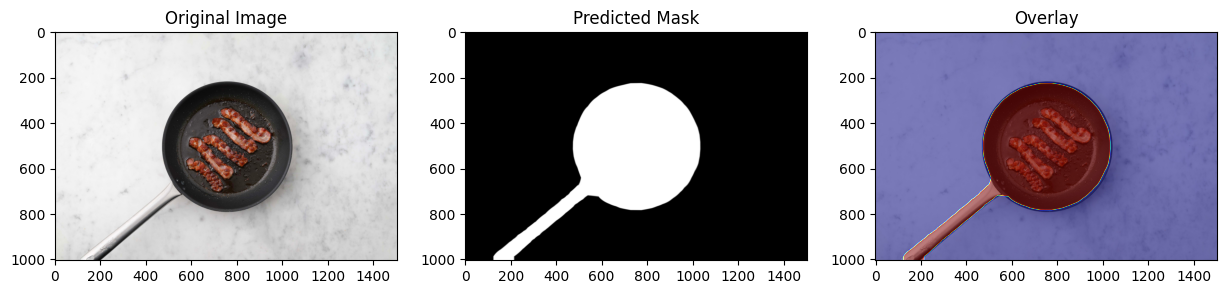

In [0]:
import sys
from pathlib import Path

root_dir = Path("<PATH>")
models_dir = root_dir / "recipe_cropper" / "models"

sys.path = [p for p in sys.path if str(models_dir) != str(Path(p))]  # Clear sys.path of any previous models_dir
sys.path.insert(0, str(models_dir)) # Add models_dir at the beginning

import json
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torch.nn.functional as F
from briaai.birefnet import BiRefNet
from briaai.BiRefNet_config import BiRefNetConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_MODEL_PATH = root_dir / "recipe_cropper" / "checkpoints" / "2025_01_29" / "briaai" / "best_model.pt"
INPUT_IMAGE_PATH = root_dir / "img_test_cropper_step_2.jpg"

with open(models_dir / "briaai" / "config.json", "r") as f:
    config = json.load(f)

# Initialize model from local files
model = BiRefNet(BiRefNetConfig(**config))

best_model_checkpoint = torch.load(BEST_MODEL_PATH)
model.load_state_dict(best_model_checkpoint["model_state_dict"])
model.to(device)
torch.set_float32_matmul_precision(['high', 'highest'][0])
model.eval()

# Data settings
image_size = (1024, 1024)
transform_image = T.Compose([
    T.Resize(image_size),
    T.ToTensor(),
    T.Lambda(lambda x: x * 0.00392156862745098),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image = Image.open(INPUT_IMAGE_PATH)
original_image_size = (image.size[1], image.size[0])
input_images = transform_image(image).unsqueeze(0).to(device)

# Prediction
with torch.no_grad():
    preds = model(input_images)
    logits = preds[0]  # Extract logits tensor
    logits = F.interpolate(logits, size=original_image_size, mode="bilinear", align_corners=False)
    pred_mask = torch.sigmoid(logits).cpu()

# Convert to PIL and resize
pred_pil = T.ToPILImage()(pred_mask.squeeze())
mask = pred_pil.resize(image.size)

# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(image)
ax1.set_title('Original Image')
ax2.imshow(mask, cmap='gray')
ax2.set_title('Predicted Mask')
ax3.imshow(image)
ax3.imshow(mask, alpha=0.5, cmap='jet')
ax3.set_title('Overlay')
plt.show()